In [1]:
from multiprocessing import Pool
import tqdm
import pickle
from pathlib import Path
from contextlib import closing
from rdkit import Chem
import numpy as np
import pandas as pd

In [2]:
import sys
sys.path.append("../../")

In [3]:
%%time
fragments_path = Path("/net/cci/cschlick/Filtered_COD3/fragments.pkl")
with fragments_path.open("rb") as fh:
  fragments = pickle.load(fh)

CPU times: user 29 s, sys: 5.02 s, total: 34 s
Wall time: 36.5 s


In [4]:
N_max = -1
angle_fragments = []
bond_fragments = []
for i,result in enumerate(fragments):
  if i<N_max or N_max == -1:
    angle_fragments+=result["angle_fragments"]
    bond_fragments+=result["bond_fragments"]

In [5]:
from phenixml.featurizers.fingerprints import MorganFeaturizer

In [7]:
def worker_angle(angle_fragment):
  angle_featurizer = MorganFeaturizer(radius=2,nBits=2048)
  return angle_featurizer.featurize(angle_fragment)

def worker_bond(bond_fragment):
  bond_featurizer = MorganFeaturizer(radius=2,nBits=2048)
  return bond_featurizer.featurize(bond_fragment)

In [8]:
work = angle_fragments
with closing(Pool(processes=32)) as pool:
  angle_features = []
  for result in tqdm.tqdm(pool.map(worker_angle, work), total=len(work)):
      angle_features.append(result)
  pool.terminate()

100%|██████████| 2657850/2657850 [00:00<00:00, 2851892.46it/s]


In [8]:
# work = bond_fragments
# with closing(Pool(processes=16)) as pool:
#   bond_features = []
#   for result in tqdm.tqdm(pool.map(worker_bond, work), total=len(work)):
#       bond_features.append(result)
#   pool.terminate()

100%|██████████| 1856810/1856810 [00:00<00:00, 2608777.63it/s]


In [11]:
angle_features = np.array(angle_features)

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [14]:
mode = "angle"
if mode =="bond":
  X = bond_features
  y =  np.array([frag.properties["bond_length"] for frag in bond_fragments])
  space = np.arange(X.shape[0])
  train, test = train_test_split(space,test_size=0.2)
  frags_train, frags_test = [angle_fragments[i] for i in train], [angle_fragments[i] for i in test]
elif mode == "angle":
  X = angle_features
  space = np.arange(X.shape[0])
  y =  np.array([frag.properties["angle_deg"] for frag in angle_fragments])
  train, test = train_test_split(space,test_size=0.2)
  frags_train, frags_test = [angle_fragments[i] for i in train], [angle_fragments[i] for i in test]
  
X_train, X_test = X[train],X[test]
y_train, y_test = y[train],y[test]

In [15]:
regressor = RandomForestRegressor(n_estimators=100,min_samples_split=2, random_state=0,n_jobs=-1)

In [16]:
%%time
regressor.fit(X_train,y_train)

CPU times: user 10d 9h 46min 39s, sys: 2h 47min 49s, total: 10d 12h 34min 28s
Wall time: 4h 6min 32s


RandomForestRegressor(n_jobs=-1, random_state=0)

In [17]:
y_pred = regressor.predict(X_test)

Text(0, 0.5, 'Predicted')

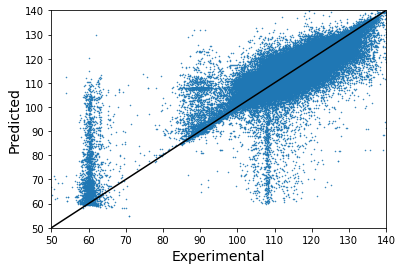

In [19]:
df = pd.DataFrame({"dists":y_test.flatten(),"pred":y_pred.flatten()})
ax = df.plot.scatter("dists","pred",s=0.25)
if mode == "bond":
  ax.set_xlim(1,1.8)
  ax.set_ylim(1,1.8)
elif mode == "angle":
  ax.set_xlim(50,140)
  ax.set_ylim(50,140)
ax.plot([0,200],[0,200],color="black")
ax.set_xlabel("Experimental",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)

(-20.0, 20.0)

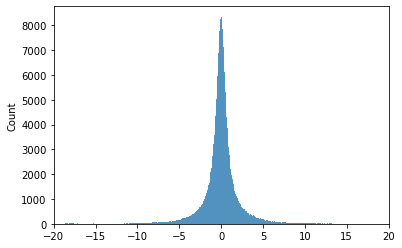

In [22]:
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
residuals = y_test-y_pred
sns.histplot(residuals)
plt.xlim(-20,20)

In [112]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE:",rmse)

RMSE: 0.0629523062426915


In [31]:
from phenixml.utils.eval_utils import tukey_test

In [ ]:
from phenixml.utils.eval_utils import tukey_test

In [ ]:
from phenixml.utils.eval_utils import tukey_test
outliers_prob,outliers_poss = tukey_test(residuals)
print(len(outliers_poss),(len(outliers_poss)/len(y_test))*100)
print(len(outliers_prob),(len(outliers_prob)/len(y_test))*100)

In [39]:
print(len(outliers_poss))
print(len(outliers_prob))

1559
543


In [23]:
print(len(angle_fragments))

2657850


In [27]:
# Dump model to disk
from joblib import dump, load
dump_path = Path("../../examples/pre_trained_models/ecfp_angles_rf_pretrained.pkl")
with dump_path.open("wb") as fh:
  dump(regressor,fh)

In [28]:
dump?

Signature: dump(value, filename, compress=0, protocol=None, cache_size=None)
Docstring:
Persist an arbitrary Python object into one file.

Read more in the :ref:`User Guide <persistence>`.

Parameters
-----------
value: any Python object
    The object to store to disk.
filename: str, pathlib.Path, or file object.
    The file object or path of the file in which it is to be stored.
    The compression method corresponding to one of the supported filename
    extensions ('.z', '.gz', '.bz2', '.xz' or '.lzma') will be used
    automatically.
compress: int from 0 to 9 or bool or 2-tuple, optional
    Optional compression level for the data. 0 or False is no compression.
    Higher value means more compression, but also slower read and
    write times. Using a value of 3 is often a good compromise.
    See the notes for more details.
    If compress is True, the compression level used is 3.
    If compress is a 2-tuple, the first element must correspond to a string
    between supported co